## Estimation of treatment effects using  Linear Regression and Generalized Random Forests
Random forests (Breiman) are known to have good performance for regression and classification tasks. However, they are not generally used for purposes of estimation of treatment effects. This is addressed in recent work on **causal trees** (Athey and Imbens) and extended further as **generalized random forests** (Athey, Tibshirani and Wager). 

Important features of this approach include
* **causal** interpretations (Rubin-causal model via _potential outcomes_).
* trying to reduce bias via _honest_ estimation where different sub samples are used for branch splits and estimation.
* combining estimation with **inference** (confidence intervals) by developing the corresponding asymptotic theory, and estimation of standard errors (for the treatment effects) using resampling methods.
* the tree and forest structures allow for estimation of _heterogenous treatment effects_. The sample is repeatedly (and _recursively_) split during the tree construction phase. All samples that are in the same (terminal) leaf node receive the same "local" prediction.  

We compare **linear regression** with **generalized random forests** (GRFs) using the CRAN package 'GRF' (Athey, Tibshirani, and Wager) for estimation of "treatment" effects of **binary variables**.

### Data and Example
The example used is a standard wage regression using data from the text _Introductory Econometrics_ (Wooldridge) obtained from the  [publisher's website](http://www.cengage.com/cgi-wadsworth/course_products_wp.pl?fid=M20b&product_isbn_issn=9781111531041).

In [1]:
load("data/wage1.RData")  #data from Cengage website for Wooldridge's intro econometrics textbook
attach(data)
dim(data)

[1] 526  24

There are 526 observations on 24 variables. 

In [2]:
names(data)

[1] "wage"     "educ"     "exper"    "tenure"   "nonwhite" "female"  
 [7] "married"  "numdep"   "smsa"     "northcen" "south"    "west"    
[13] "construc" "ndurman"  "trcommpu" "trade"    "services" "profserv"
[19] "profocc"  "clerocc"  "servocc"  "lwage"    "expersq"  "tenursq"

For illustrative example we focus on the following subset variables (as in standard examples, e.g. Wooldridge's text). 

In [3]:
desc[c(1,2,3,4,6,7,22),] #the main variables of interest for illustrative example

,variable,label
1,wage,average hourly earnings
2,educ,years of education
3,exper,years potential experience
4,tenure,years with current employer
6,female,=1 if female
7,married,=1 if married
22,lwage,log(wage)


In [4]:
summary(data[,c(1,2,3,4,6,7)])

      wage             educ           exper           tenure      
 Min.   : 0.530   Min.   : 0.00   Min.   : 1.00   Min.   : 0.000  
 1st Qu.: 3.330   1st Qu.:12.00   1st Qu.: 5.00   1st Qu.: 0.000  
 Median : 4.650   Median :12.00   Median :13.50   Median : 2.000  
 Mean   : 5.896   Mean   :12.56   Mean   :17.02   Mean   : 5.105  
 3rd Qu.: 6.880   3rd Qu.:14.00   3rd Qu.:26.00   3rd Qu.: 7.000  
 Max.   :24.980   Max.   :18.00   Max.   :51.00   Max.   :44.000  
     female          married      
 Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :1.0000  
 Mean   :0.4791   Mean   :0.6084  
 3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000  

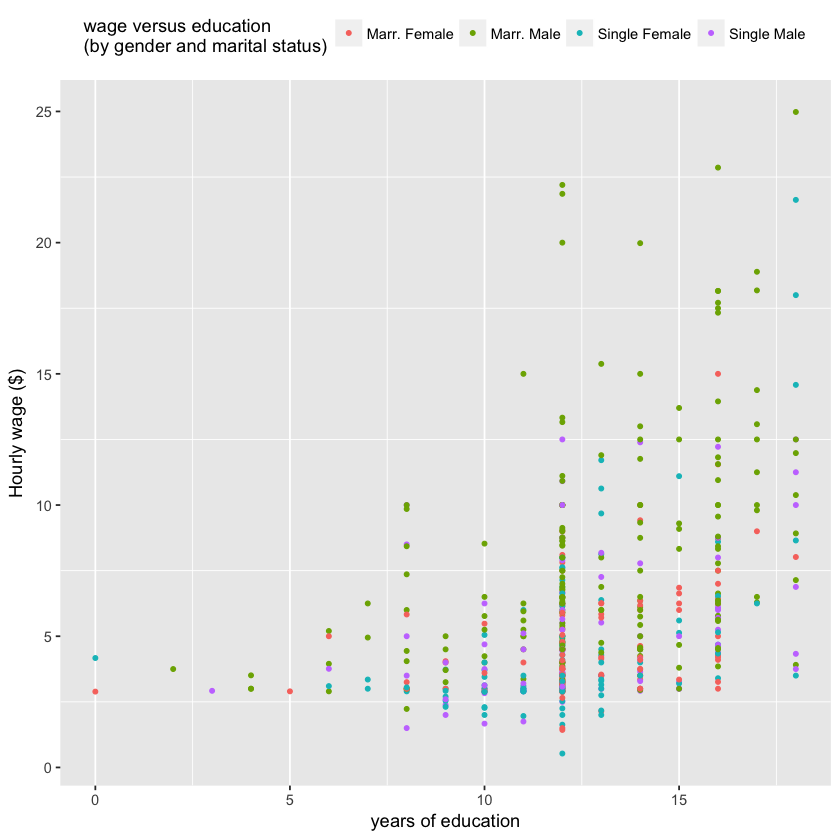

In [5]:
library(ggplot2)
# Simple plot to show hourly wage vs education for men/women and marital status 
group<-rep("Single Female", length(female))
group[which(female==0 & married==0)] <- "Single Male"
group[which(female==0 & married==1)] <- "Marr. Male"
group[which(female==1 & married==1)] <- "Marr. Female"

layer_point1 <- geom_point(mapping = aes(x=educ, y=wage, color = group),size=1)
p0 <- ggplot() + layer_point1 + labs(x="years of education", 
                               y="Hourly wage ($)", 
                               color="wage versus education \n(by gender and marital status)") +
    theme(panel.grid.major.y = element_blank()) +
    theme(legend.position="top")
print(p0)

_In this dataset_, gender and marital status appear to have some influence on hourly wages. We will try to estimate the size of these effects using multiple linear regression and generalized random forests.  

### Comparison of fit
Before getting into estimation, we compare the fit (predictions) from linear regression with those from random forests. The basic multiple regression model used throughout is

#### Split dataset into training and test subsamples

In [6]:
#for training
idx.train <- sample(nrow(data), 1/2 * nrow(data)) #just an index of the random subsample
Y.train<- with(data[idx.train,], lwage)  #response 
X.train<- with(data[idx.train,], cbind(educ, exper, tenure, female, married)) #covariates

#For testing
Y.test<- with(data[-idx.train,], lwage)  #response
X.test<-data.frame(with(data[-idx.train,], cbind(educ, exper, tenure, female, married)))

#### Fit a linear regression and obtain predictions
$$
\log(wage) = \beta_{0} + \beta_{1}educ + \beta_{2}exper + \beta_{3}exper^{2} + \beta_{4}tenure + \beta_{5}tenure^{2} +
\beta_{5}female + \beta_{6}married + \beta_{7}female\cdot married + error
$$

As is standard, the regression model includes quadractics and an interaction term as well. 

In [7]:
model_Linear <- lm(lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + female + married + I(female*married), data=data[idx.train,])		
predictLinear<-predict(model_Linear, newdata=X.test)

#### Fit a random forest and obtain predictions

In [8]:
library(grf)
modelGRF <- regression_forest(X.train,Y.train) #
predictGRF <- predict(modelGRF, newdata=X.test)

Warning message:
“package ‘grf’ was built under R version 3.4.3”

In [9]:
#function to get sum of squares
vec_ssr <-function(vec){
	return(sum(vec^2))
} 

#### Calculate the ratio of sum of squared residuals to total sum of squares (R squared)

In [10]:
preds<- cbind(predictLinear-Y.test, predictGRF$predictions-Y.test); colnames(preds) <- c("Linear Reg.", "GRF");
ssr_preds <- apply(preds, 2, vec_ssr)
ratio_ssr_sst <- ssr_preds/(var(Y.test)*(length(Y.test)-1))  #Rsquared: sum of squared residuals to total sum of squares
r1<-as.numeric(ratio_ssr_sst[1]); r2<-as.numeric(ratio_ssr_sst[2]);

#### Plot the predictions

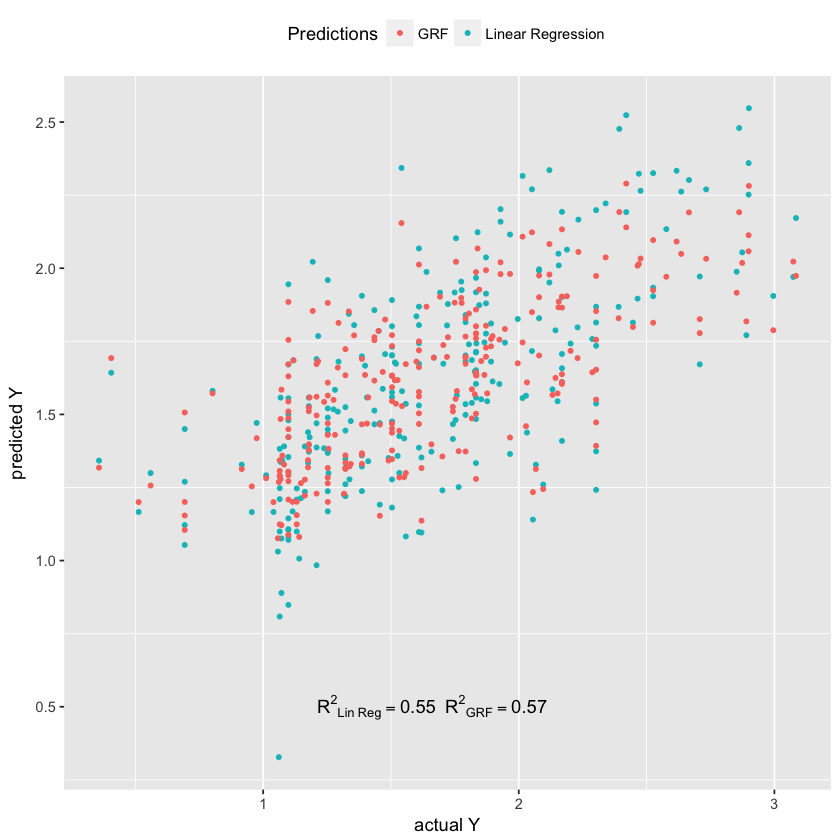

In [11]:
idx <- c(rep("Linear Regression",length(Y.test)),rep("GRF",length(Y.test)))
infoTxt <- paste0("{R^2}[Lin~Reg]"," == ",  as.character(format(r1, digits=2)),
                  "~~{R^2}[GRF]"," == ",  as.character(format(r2, digits=2)))
layerPreds <- geom_point(mapping = aes(
    x=c(Y.test,Y.test),
    y = c(predictLinear,predictGRF$predictions),
    color = idx),
    size=1)
ggplot() + layerPreds  +
    labs(x="actual Y", y="predicted Y", color="Predictions") +
    annotate("text", x=mean(Y.test), y=.5, label= infoTxt, parse=T)  +
    theme(panel.grid.major.y = element_blank()) + theme(legend.position="top")

#### Prediction comparisons for multiple runs
The same code as above, but now inside a loop for multiple runs and grid layout for plotting.

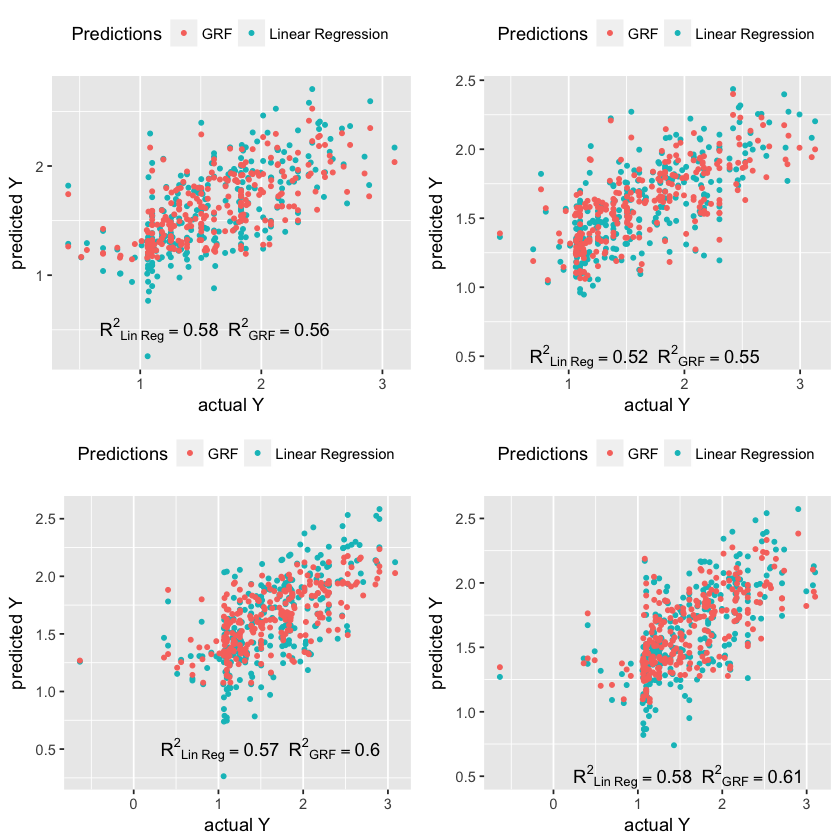

In [12]:
library(grid)
numr <-2 ; numc <- 2
pushViewport(viewport(layout = grid.layout(numr,numc)))

for(i in 1:numr){
	for(j in 1:numc){
		#split dataset into training and test samples
		idx.train <- sample(nrow(data), 1/2 * nrow(data)) #just an index of the random subsample
		Y.train<- with(data[idx.train,], lwage)  #response 
		X.train<- with(data[idx.train,], cbind(educ, exper, tenure, female, married)) #covariates
		
		#For testing
		Y.test<- with(data[-idx.train,], lwage)  #response
		X.test<-data.frame(with(data[-idx.train,], cbind(educ, exper, tenure, female, married)))
				
		#fit a linear model
		model_Linear <- lm(lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + female + married + I(female*married), data=data[idx.train,])		
		predictLinear<-predict(model_Linear, newdata=X.test)
		
		#regression forest for prediction (not causal forest, which is for estimation of treatment effect)
		modelGRF = regression_forest(X.train,Y.train) #
		predictGRF = predict(modelGRF, newdata=X.test)
		#obtain sum of squared residuals
		preds<- cbind(predictLinear-Y.test, predictGRF$predictions-Y.test); colnames(preds) <- c("Linear Reg.", "GRF");
		ssr_preds <- apply(preds, 2, vec_ssr)
		ratio_ssr_sst <- ssr_preds/(var(Y.test)*(length(Y.test)-1))  #Rsquared: sum of squared residuals to total sum of squares
		r1<-as.numeric(ratio_ssr_sst[1]); r2<-as.numeric(ratio_ssr_sst[2]);
		idx <- c(rep("Linear Regression",length(Y.test)),rep("GRF",length(Y.test)))
			
		infoTxt = paste0("{R^2}[Lin~Reg]"," == ",  as.character(format(r1, digits=2)), "~~{R^2}[GRF]"," == ",  as.character(format(r2, digits=2)))
		
		layerPreds <- geom_point(mapping = aes(x=c(Y.test, Y.test), y = c(predictLinear,predictGRF$predictions),color = idx),size=1)
		p1 <- ggplot() + layerPreds  + labs(x="actual Y", y="predicted Y", color="Predictions") + annotate("text", x=mean(Y.test), y=.5, label= infoTxt, parse=T)  + theme(panel.grid.major.y = element_blank()) + theme(legend.position="top")

	print(p1, vp = viewport(layout.pos.row = i , layout.pos.col = j ))
	}
}


As expected, the random forest predictions are generally better than those from linear regression.

### Moving on to estimation
This is the novel part of the analysis based on the papers of (and GRF package by) Athey, Imbens, Tibshirani, and Wager. The idea is to estimate _**unobserved potential outcomes**_ and use them to estimate average treatment effects within each leaf of a regression tree. 

#### Estimation with linear regression
For estimation, we use the entire sample.

In [13]:
Y<- with(data, lwage)  #response log wage
X<- with(data, cbind(educ, exper, tenure, female, married)) #covariates

#Fit a linear model with interaction and quadratic terms
model_Linear <- lm(lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + female + married + I(female*married), data=data)
summary(model_Linear)


Call:
lm(formula = lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + 
    female + married + I(female * married), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.89697 -0.24060 -0.02689  0.23144  1.09197 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.3213781  0.1000090   3.213 0.001393 ** 
educ                 0.0789103  0.0066945  11.787  < 2e-16 ***
exper                0.0268006  0.0052428   5.112 4.50e-07 ***
I(exper^2)          -0.0005352  0.0001104  -4.847 1.66e-06 ***
tenure               0.0290875  0.0067620   4.302 2.03e-05 ***
I(tenure^2)         -0.0005331  0.0002312  -2.306 0.021531 *  
female              -0.1103502  0.0557421  -1.980 0.048272 *  
married              0.2126757  0.0553572   3.842 0.000137 ***
I(female * married) -0.3005931  0.0717670  -4.188 3.30e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3933 on 517 degrees

The coefficients have straightforward interpretations. We just need to remember that the response is logarithm of wage, so the interpretation will be 
* based on **percent differences** in hourly wages, and 
* the reference group is "single men" (i.e. female =0, married =0). 

For example, the coefficient on married (0.2126) indicates that married men earn _approximately_ 21% higher than single men. This is after controlling for other covariates such as education and experience. 

The exact percentage difference in hourly wage (because Y is log(wage)) is given by 
$$
(\exp(\beta_{i})-1)\times 100 
$$

In [14]:
marrMale.lm <- 100*(exp(model_Linear$coef["married"])-1) #percent difference in hourly wage (Ref: single male)

In [15]:
print(format(marrMale.lm, digits=4), quote=F)

married 
   23.7 


Thus, controlling for education, experience, and tenure at current job, married men earn about 24% higher than single men. The other coefficients have similar interpretations. Create a table to summarize the estimated differences between various groups. 

In [16]:
#use coefficients from linear regression to obtain estimates of differences
est.lm <- rbind(model_Linear$coef["female"], # single women compared to single men
  model_Linear$coef["female"] + model_Linear$coef["I(female * married)"], # married women compared to married men
	 model_Linear$coef["married"]+ model_Linear$coef["I(female * married)"],# married women vs single women
	 model_Linear$coef["married"]) #marr. men vs. single men
rownames(est.lm) <- c("Sing. Women vs. Sing. Men", "Marr. Women vs. Marr. Men", "Marr. Women vs. Sing. Women", "Marr. Men vs. Sing. Men" )

#get the corresponding variances
se.lm <- rbind(vcov(model_Linear)["female","female"],
vcov(model_Linear)["female","female"] + vcov(model_Linear)["I(female * married)","I(female * married)"] + 2*vcov(model_Linear)["I(female * married)","female"],
vcov(model_Linear)["married","married"] + vcov(model_Linear)["I(female * married)","I(female * married)"] + 2*vcov(model_Linear)["I(female * married)","female"],
vcov(model_Linear)["married","married"])  

se.lm <- sqrt(se.lm) #convert variances to standard errors

est.lm <- cbind(est.lm, se.lm, est.lm/se.lm)
colnames(est.lm) <- c("estimate.lm", "std. error", "t-val")

est.lm


,estimate.lm,std. error,t-val
Sing. Women vs. Sing. Men,-0.11035021,0.05574205,-1.979658
Marr. Women vs. Marr. Men,-0.41094328,0.04577091,-8.978263
Marr. Women vs. Sing. Women,-0.08791739,0.04530140,-1.940721
Marr. Men vs. Sing. Men,0.21267568,0.05535718,3.841881


#### Estimation with random forests
The GRF package functions **_causal_\_ _forest_( )** and **_estimate_\_ _average_\_ _effect_( )** are used to fit a **causal** forest, and to estimate treatment effects using the fitted forest. As these are designed for binary treatment effects, (using them directly) one can only obtain an estimate for the impact of gender alone  (regardless of marital status) or vice versa. 

In order to obtain estimates that can be compared with those from linear regression, define a convenience function that offers some flexibility. 

In [17]:
ate_mult <- function(X,Y,t_var="treat_var", gp = "group", gp_ind =0){
	idx <- which(X[,gp]==gp_ind) #group index e.g. "married"
	X.causal <- X[ , -which(colnames(X) == t_var | colnames(X) == gp)] #separate treatment var and group indictor from other covariates
	W.causal <- X[ , which(colnames(X) == t_var)]  # binary indicator for treatment.
	model_GRF_causalFor = causal_forest(X.causal[idx,], Y[idx], W.causal[idx]) #fit causal forest
	ate <- estimate_average_effect(model_GRF_causalFor, target.sample = "all") #estimate treatment effect
	return(ate)
}

Using this, we can now obtain estimates that can be compared to the ones obtained from linear regression. For example,

In [18]:
ate_fem_single<- ate_mult(X,Y,t_var="female", gp="married", gp_ind=0) #pick all single workers, estimate effect of gender

In [19]:
ate_fem_single

estimate     std.err 
-0.11659468  0.05981025

Thus, single women earn about 12% less than single men. The other group differences can be estimated similarly.

In [20]:
ate_fem_married<- ate_mult(X,Y,t_var="female", gp="married", gp_ind=1) #pick all married workers, estimate effect of gender

ate_marr_for_women<- ate_mult(X,Y,t_var="married", gp="female", gp_ind=1) #pick all women workers, estimate effect of marital status
 
ate_marr_for_men<- ate_mult(X,Y,t_var="married", gp="female", gp_ind=0)  #pick all men workers, estimate effect of marital status
 
est.grf <-rbind(ate_fem_single,ate_fem_married,ate_marr_for_women,ate_marr_for_men)
est.grf <- cbind(est.grf,est.grf[,1]/est.grf[,2])   #t values may be smaller: subsampling (for groups + "honesty")
colnames(est.grf) <- c("estimate.grf","std. error", "t-val")
rownames(est.grf) <- c("Sing. Women vs. Sing. Men", "Marr. Women vs. Marr. Men", "Marr. Women vs. Sing. Women", "Marr. Men vs. Sing. Men" )
est.grf

,estimate.grf,std. error,t-val
Sing. Women vs. Sing. Men,-0.11659468,0.05981025,-1.949410
Marr. Women vs. Marr. Men,-0.40780063,0.04796048,-8.502848
Marr. Women vs. Sing. Women,-0.02062742,0.06015807,-0.342887
Marr. Men vs. Sing. Men,0.16705688,0.08191812,2.039315


recall the linear regression estimates

In [21]:
est.lm

,estimate.lm,std. error,t-val
Sing. Women vs. Sing. Men,-0.11035021,0.05574205,-1.979658
Marr. Women vs. Marr. Men,-0.41094328,0.04577091,-8.978263
Marr. Women vs. Sing. Women,-0.08791739,0.04530140,-1.940721
Marr. Men vs. Sing. Men,0.21267568,0.05535718,3.841881


The estimated wage gap between men and women workers with the _same marital status_ are nearly identical across the two models: about 11 percent lower for single women relative to single men and 40 percent lower for married women relative to married men. 

However, the estimated wage gap between married and single workers of _the same gender_ are higher in linear regression. Married women earn 9% lower wages than single women in the linear model, while the non-parametric random forest estimate is only about 2% (and not statistically significant). For men, linear regression suggests married men earn 21% higher than single men, while the causal forest estimate of the same gap is 17%.

But this comparison is not really valid as the linear regression estimates are from the full sample, while the GRF estimates are from subsamples (grouped by gender or marital status). So lets run the linear regression again, but now only on the same subsamples.

In [2]:
#imapct of gender
model_Linear_Gender_singles <- lm(lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + female, data=data[which(married==0),])

model_Linear_Gender_marr <- lm(lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + female, data=data[which(married==1),])

#Impact of marital status
model_Linear_MarrStat_men <- lm(lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + married, data=data[which(female==0),])

model_Linear_MarrStat_women <- lm(lwage ~ educ + exper + I(exper^2) + tenure + I(tenure^2) + married, data=data[which(female==1),])


est.lm.gp <- rbind(model_Linear_Gender_singles$coef["female"], # single women compared to single men
  model_Linear_Gender_marr$coef["female"], # married women compared to married men
	 model_Linear_MarrStat_women$coef["married"],# married women vs single women
	 model_Linear_MarrStat_men$coef["married"]) #marr. men vs. single men
rownames(est.lm.gp) <- c("Sing. Women vs. Sing. Men", "Marr. Women vs. Marr. Men", "Marr. Women vs. Sing. Women", "Marr. Men vs. Sing. Men" )

#get the corresponding variances
se.lm.gp <- rbind(vcov(model_Linear_Gender_singles)["female","female"],
vcov(model_Linear_Gender_marr)["female","female"],
vcov(model_Linear_MarrStat_women)["married","married"],
vcov(model_Linear_MarrStat_men)["married","married"])  

se.lm.gp <- sqrt(se.lm.gp) #convert variances to standard errors

est.lm.gp <- cbind(est.lm.gp, se.lm.gp, est.lm.gp/se.lm.gp)
colnames(est.lm.gp) <- c("estimate.lm.gp", "std. error", "t-val")

est.lm.gp

,estimate.lm.gp,std. error,t-val
Sing. Women vs. Sing. Men,-0.12853151,0.05749653,-2.235466
Marr. Women vs. Marr. Men,-0.41361414,0.04537554,-9.115354
Marr. Women vs. Sing. Women,-0.05476556,0.05387813,-1.016471
Marr. Men vs. Sing. Men,0.17176140,0.05948349,2.887548


 These estimates (and the standard errors) are now closer to those for the random forest. 